In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.stats as stats
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm

# Project Description

This project aims to predict the price of a car based on several features. The features in the dataset include name, year, price, kilometers, fuel type, seller type, transmission type, and how many owners the car has had. Because price is a continuous variable, this would be a regression problem and not a classification problem.


In [41]:
car_data = pd.read_csv('../Downloads/CAR DETAILS FROM CAR DEKHO.csv')
car_data.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner


# Examining the Dataset

AKSHAY DATTATRAY KHARE (October 2022). Car Details Dataset.

Retrieved November 2022 from https://www.kaggle.com/datasets/akshaydattatraykhare/car-details-dataset.


I found the data via kaggle and the data was sourced from Car Dekho. 

### Overview of Data Types and Shape

The dataset includes 4340 car entries with the 8 total attributes for each car. There are 

In [42]:
car_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   name           4340 non-null   object
 1   year           4340 non-null   int64 
 2   selling_price  4340 non-null   int64 
 3   km_driven      4340 non-null   int64 
 4   fuel           4340 non-null   object
 5   seller_type    4340 non-null   object
 6   transmission   4340 non-null   object
 7   owner          4340 non-null   object
dtypes: int64(3), object(5)
memory usage: 271.4+ KB


### Checking for Null Values
The data is very clean, with no null values in any of the columns.

In [43]:
car_data.isnull().sum()

name             0
year             0
selling_price    0
km_driven        0
fuel             0
seller_type      0
transmission     0
owner            0
dtype: int64

### Categorical Attribute Values:
3 of the attributes are integers (year, selling_price, and km_driven), and 5 are categorical(name, fuel type, seller type, transmission type, and owner type). 

In [44]:
print("Categorical Variable Attributes:\n")
print("Number of Vehicle Types: ", len(car_data.name.unique()))
print("Fuel Types: ", car_data.fuel.unique())
print("Seller Types: ", car_data.seller_type.unique())
print("Transmission Types: ", car_data.transmission.unique())
print("Owner Types: ", car_data.owner.unique())

Categorical Variable Attributes:

Number of Vehicle Types:  1491
Fuel Types:  ['Petrol' 'Diesel' 'CNG' 'LPG' 'Electric']
Seller Types:  ['Individual' 'Dealer' 'Trustmark Dealer']
Transmission Types:  ['Manual' 'Automatic']
Owner Types:  ['First Owner' 'Second Owner' 'Fourth & Above Owner' 'Third Owner'
 'Test Drive Car']


### Integer Attribute Values

Below is a description of the numerican data:

In [45]:
car_data.describe().round()

,year,selling_price,km_driven
count,4340.0,4340.0,4340.0
mean,2013.0,504127.0,66216.0
std,4.0,578549.0,46644.0
min,1992.0,20000.0,1.0
25%,2011.0,208750.0,35000.0
50%,2014.0,350000.0,60000.0
75%,2016.0,600000.0,90000.0
max,2020.0,8900000.0,806599.0


# Data Cleaning

### Converting Units

The currency used was not mentioned, but when I looked up Car Dekho, I learned that it is a website for buying and selling used cars in India. Because of this, I will:

1) Convert the currency from rupees to dollars by multiplying by the conversion rate of 0.012.

2) Convert km_driven to mi_driven by multiplying by the conversion rate of 0.621371.

3) Convert owner type from a categorical value to an integer value.

In [46]:
#1) Convert to USD:

rupee_to_usd_conversion = 0.012

car_data.selling_price = car_data.selling_price*rupee_to_usd_conversion
car_data.selling_price = car_data.selling_price.astype(int)

In [47]:
#2) Convert to Miles:

km_to_mi_conversion = 0.621371

car_data.km_driven = car_data.km_driven*km_to_mi_conversion
car_data.km_driven = car_data.km_driven.astype('int')
car_data = car_data.rename(columns={'km_driven':'mi_driven'})

In [48]:
#3) Convert owner type to an integer value:

mapping = {'Test Drive Car': int(0),
           'First Owner': int(1),
           'Second Owner': int(2),
           'Third Owner': int(3),
           'Fourth & Above Owner': int(4)}

car_data['owner'] = car_data['owner'].map(mapping)

In [49]:
car_data.head()

,name,year,selling_price,mi_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,720,43495,Petrol,Individual,Manual,1
1,Maruti Wagon R LXI Minor,2007,1620,31068,Petrol,Individual,Manual,1
2,Hyundai Verna 1.6 SX,2012,7200,62137,Diesel,Individual,Manual,1
3,Datsun RediGO T Option,2017,3000,28583,Petrol,Individual,Manual,1
4,Honda Amaze VX i-DTEC,2014,5400,87613,Diesel,Individual,Manual,2


### Derriving Categorical Value for Luxury, Standard and Budget Brand Cars

I want to examine whether or not classifying cars as budget, standard, or luxury cars would be helpful for the model. To do this I will:

1) Adjust the name attribute to only include the car brand

2) Group the cars by brand and calculate the mean selling price for each brand

3) Identify the 25th and 75th percentile

4) Label the brands that are in the 66th percentile or above as luxury brands, brands that are in the 33rd percentile or below as budget brands, and brands that are between the 33rd and 66th percentile as standard brands.

In [50]:
#1) Adjust Name Attribute to only include the car brand
car_data['name'] = car_data['name'].str.split().str[0]
print(car_data['name'])

0        Maruti
1        Maruti
2       Hyundai
3        Datsun
4         Honda
         ...   
4335    Hyundai
4336    Hyundai
4337     Maruti
4338    Hyundai
4339    Renault
Name: name, Length: 4340, dtype: object


In [51]:
#2) Group Cars by brand and calculate the mean selling price for each brand
grouped_cars = car_data.groupby('name')
mean_price_by_brand = grouped_cars.selling_price.mean()
print("Average Price By Brand: ", mean_price_by_brand.astype(int))

Average Price By Brand:  name
Ambassador        2160
Audi             23179
BMW              35344
Chevrolet         2840
Daewoo             720
Datsun            3564
Fiat              3401
Force             4152
Ford              6855
Honda             6457
Hyundai           5039
Isuzu            18000
Jaguar           24829
Jeep             18360
Kia              15600
Land             43317
MG               22110
Mahindra          7052
Maruti            4108
Mercedes-Benz    33319
Mitsubishi       10080
Nissan            5399
OpelCorsa         1062
Renault           5032
Skoda             5880
Tata              3408
Toyota           11092
Volkswagen        5652
Volvo            30675
Name: selling_price, dtype: int64


In [52]:
#3) Identify the 25th and 75th percentiles.
percentile_cutoff33 = np.percentile(mean_price_by_brand, 33)
print("Value of 33rd Percentile: ", int(percentile_cutoff25))

percentile_cutoff66 = np.percentile(mean_price_by_brand, 66)
print("Value of 66th Percentile: ", int(percentile_cutoff75))

Value of 25th Percentile:  5034
Value of 75th Percentile:  13255


In [53]:
#4) Labeling brands as budget, standard, and luxury based on percentile of mean selling type by brand.
luxury = []
budget = []
standard = []
for brand, price in mean_price_by_brand.iteritems():
    if price >= percentile_cutoff66:
        luxury.append(brand)
    if price <= percentile_cutoff33:
        budget.append(brand)
    if price > percentile_cutoff33 and price < percentile_cutoff66:
        standard.append(brand)

print("Budget Brands Include: ", budget, "\n")
print("Standard Brands Include: ", standard, "\n")
print("Luxury Brands Include: ", luxury, "\n")

Budget Brands Include:  ['Ambassador', 'Chevrolet', 'Daewoo', 'Datsun', 'Fiat', 'Force', 'Maruti', 'OpelCorsa', 'Renault', 'Tata'] 

Standard Brands Include:  ['Ford', 'Honda', 'Hyundai', 'Mahindra', 'Mitsubishi', 'Nissan', 'Skoda', 'Toyota', 'Volkswagen'] 

Luxury Brands Include:  ['Audi', 'BMW', 'Isuzu', 'Jaguar', 'Jeep', 'Kia', 'Land', 'MG', 'Mercedes-Benz', 'Volvo'] 



In [54]:
#5) Create new column for class of car in the dataframe.
car_class = []

for name in car_data.name:
    if name in budget:
        car_class.append('Budget')
    if name in standard:
        car_class.append('Standard')
    if name in luxury:
        car_class.append("Luxury")

car_data['car_class'] = car_class

print(car_data.head())

      name  year  selling_price  mi_driven    fuel seller_type transmission  \
0   Maruti  2007            720      43495  Petrol  Individual       Manual   
1   Maruti  2007           1620      31068  Petrol  Individual       Manual   
2  Hyundai  2012           7200      62137  Diesel  Individual       Manual   
3   Datsun  2017           3000      28583  Petrol  Individual       Manual   
4    Honda  2014           5400      87613  Diesel  Individual       Manual   

   owner car_class  
0      1    Budget  
1      1    Budget  
2      1  Standard  
3      1    Budget  
4      2  Standard  


### Examining Outliers

In [55]:
car_data.describe().round()

,year,selling_price,mi_driven,owner
count,4340.0,4340.0,4340.0,4340.0
mean,2013.0,6049.0,41144.0,1.0
std,4.0,6943.0,28983.0,1.0
min,1992.0,240.0,0.0,0.0
25%,2011.0,2505.0,21747.0,1.0
50%,2014.0,4200.0,37282.0,1.0
75%,2016.0,7200.0,55923.0,2.0
max,2020.0,106800.0,501197.0,4.0


Looking at this description of the numerical data, there are some things I want to look into. First, the maximum value for miles driven is 501,197 miles when the 25th percentile is only 21,747. Also, the minimum year is 1992 when the 25th percentile is 2011. To see the full picture, I will create a box and whisker plot:

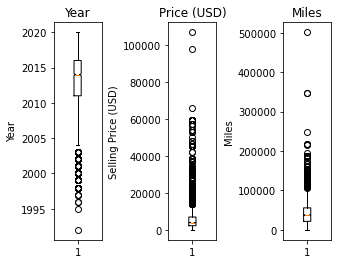

In [56]:
plt.subplot(1,6,1)
plt.boxplot(car_data.year, 'bo')
plt.title('Year')
plt.ylabel('Year')

plt.subplot(1,6,3)
plt.boxplot(car_data.selling_price, 'bo')
plt.title('Price (USD)')
plt.ylabel('Selling Price (USD)')

plt.subplot(1,6,5)
plt.boxplot(car_data.mi_driven, 'bo')
plt.title('Miles')
plt.ylabel('Miles')

plt.show;

These plots show that there are a significant amount of outliers. I first take a look at cars that have more than 200,000 miles.

In [57]:
print('Number of cars with more than 200,000 miles: ', len(car_data[car_data['mi_driven'] > 200000]))
print(car_data[car_data['mi_driven'] > 200000])

Number of cars with more than 200,000 miles:  7
           name  year  selling_price  mi_driven    fuel seller_type  \
69    Chevrolet  2010           3360     217479  Diesel  Individual   
525      Maruti  2016           7980     347967  Diesel      Dealer   
1243     Maruti  2009           3000     501197  Petrol      Dealer   
2394     Toyota  2009           4200     217479  Diesel  Individual   
3679     Toyota  2006           4800     248548  Diesel  Individual   
3718     Toyota  2009           5040     215671  Diesel      Dealer   
4184     Maruti  2016           7980     347967  Diesel      Dealer   

     transmission  owner car_class  
69         Manual      2    Budget  
525        Manual      1    Budget  
1243       Manual      1    Budget  
2394       Manual      1  Standard  
3679       Manual      3  Standard  
3718       Manual      1  Standard  
4184       Manual      1    Budget  


Luckily, there are only 7. However, two seem to be identical, which tells me there may be duplicate entries in the dataset. I will explore this after addressing the outliers. Although the box and whisker plot shows many outliers, it seems reasonable that a used car can have 200,000 miles, so I will only remove these 7 values.

In [58]:
car_data = car_data[car_data['mi_driven'] < 200000]

Next I will remove cars that are more than 20 years old. A 20 year old car is considered a classic car, so 20 years or newer seems like a reasonable adjustment that will eliminate 61 cars.

In [59]:
print('Number of cars older than 2002: ', len(car_data[car_data['year'] < 2002]))
car_data = car_data[car_data['year'] > 2002]

Number of cars older than 2002:  61


Lastly, it seems unlikely that a used car would sell for more than 70,000 dollars unless it is an exclusive vehicle, so I will remove the 2 values that have a selling price over 70,000 dollars.

In [60]:
print('Number of cars priced at $65,000+: ', len(car_data[car_data['selling_price'] > 65000]))
car_data = car_data[car_data['selling_price'] < 65000]

Number of cars priced at $65,000+:  3


### Handling Duplicate Values

Since I saw a duplicate value when looking at the outliers, I wanted to be sure there are not a lot of duplicate values. To do this I will:

1) Calculate the number of duplicate values.

2) Remove duplicate values, because it seems unlikely that there would be cars for sale with the exact same milage, year, price, owner type, etc.



In [61]:
#1) Counting Duplicate Values
print('There are ', len(car_data[car_data.duplicated()]), 'duplicate entries')

car_data = car_data.drop_duplicates()
print('There are now ', len(car_data[car_data.duplicated()]), 'duplicate entries')

There are  778 duplicate entries
There are now  0 duplicate entries


### Feature Importance

Instead of using all data in the dataset, I think it would be more productive to narrow down some of the attributes. To do this I will,

1) Remove all electric, natural gas, and propane gas vehicles (Fuel Type = Electric, CNG, and LPG)

2) Merge Dealer with Trustmark Dealer (Seller Type = Dealer and Trustmark Dealer)

3) Remove all cars that have 0 had owners (Test Drive Cars), because we are trying to predict used cars (owner > 0)

4) Examine seller_type, and decide on it's usefulness

In [62]:
print("Number of Electric Vehicles: ", len(car_data[car_data['fuel'] == 'Electric']))
print("Number of CNG Vehicles: ",len(car_data[car_data['fuel'] == 'CNG']))
print("Number of LPG Vehicles: ",len(car_data[car_data['fuel'] == 'LPG']), "\n")

car_data = car_data[car_data['fuel'] != 'CNG']
car_data = car_data[car_data['fuel'] != 'LPG']
car_data = car_data[car_data['fuel'] != 'Electric']

print("Number of Electric Vehicles: ", len(car_data[car_data['fuel'] == 'Electric']))
print("Number of CNG Vehicles: ",len (car_data[car_data['fuel'] == 'CNG']))
print("Number of LPG Vehicles: ",len(car_data[car_data['fuel'] == 'LPG']))

Number of Electric Vehicles:  1
Number of CNG Vehicles:  37
Number of LPG Vehicles:  21 

Number of Electric Vehicles:  0
Number of CNG Vehicles:  0
Number of LPG Vehicles:  0


In [63]:
print("Number of cars sold by Dealers: ", len(car_data[car_data['seller_type'] == 'Dealer']))
print("Number of cars sold by Trustmark Dealers: ", len(car_data[car_data['seller_type'] == 'Trustmark Dealer']), "\n")

car_data['seller_type'] = car_data['seller_type'].map({'Trustmark Dealer': 'Dealer', 'Dealer':'Dealer', 'Individual': 'Individual'})

print("Number of cars sold by Dealers: ", len(car_data[car_data['seller_type'] == 'Dealer']))
print("Number of cars sold by Trustmark Dealers: ", (car_data[car_data['seller_type'] == 'Trustmark Dealer']).size, "\n")

Number of cars sold by Dealers:  692
Number of cars sold by Trustmark Dealers:  33 

Number of cars sold by Dealers:  725
Number of cars sold by Trustmark Dealers:  0 



In [64]:
print("Number of test drive cars: ", len(car_data[car_data['owner'] == 0]))
car_data = car_data[car_data['owner'] != 0]
print("Number of test drive cars: ", len(car_data[car_data['owner'] == 0]))

Number of test drive cars:  17
Number of test drive cars:  0


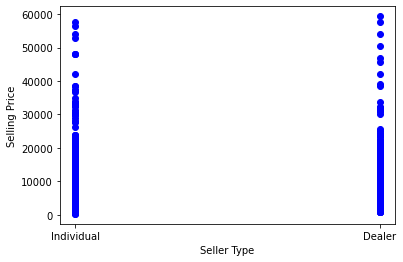

In [26]:
plt.plot(car_data.seller_type, car_data.selling_price, 'bo')
plt.ylabel('Selling Price')
plt.xlabel('Seller Type');

Based on this plot of selling price based on seller type, it appears that seller_type has little importance in determining the selling price. I may want to remove this feature, but I am curious to examine how it impacts the adjusted R^2 value if I include it in my model so I will keep it for now, but I will most likely remove it.

# Examining Distribution of the Data

Based on the long tails in plots below, it is clear that there are still outliers that may impact the analysis. However, I am hoping that classifying vehicles as luxury, standard, or buget will help account for the large tails in the price distribution.

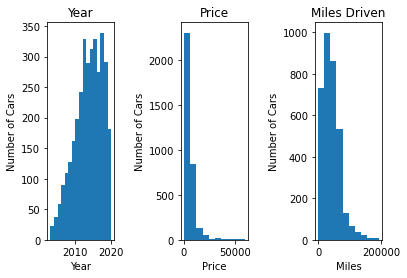

In [65]:
plt.subplot(1,3,1)
plt.hist(car_data.year, bins=(car_data.year.max()-car_data.year.min()))
plt.title('Year')
plt.ylabel('Number of Cars')
plt.xlabel('Year')

plt.subplot(1,3,2)
plt.hist(car_data.selling_price)
plt.title('Price')
plt.ylabel('Number of Cars')
plt.xlabel('Price')

plt.subplot(1,3,3)
plt.hist(car_data.mi_driven);
plt.title('Miles Driven')
plt.ylabel('Number of Cars')
plt.xlabel('Miles')

plt.subplots_adjust(wspace=1)
plt.show()



# Examining Correlations

Now that the data is clean, I want to take a look at the overall correlations of the numerical data:

                   year  selling_price  mi_driven     owner
year           1.000000       0.451812  -0.472280 -0.449540
selling_price  0.451812       1.000000  -0.198405 -0.236731
mi_driven     -0.472280      -0.198405   1.000000  0.347526
owner         -0.449540      -0.236731   0.347526  1.000000


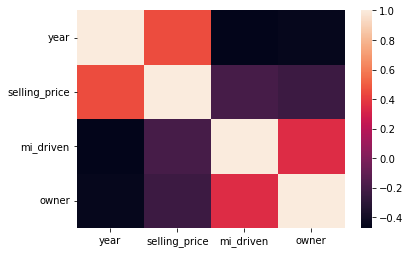

In [66]:
sns.heatmap(car_data.corr());
print(car_data.corr())

As we can see in the plots, years is the variable that is most correlated with selling price. I am assuming this will result in year being the feature that results in the largest adjusted R^2 value in the forward selection model. Year is also significantly coorilated with all other variables, but I don't think that it is so significant that it will result in problematic multicolinearity.


Interestingly, miles driven is not as corrilated with selling price. I assumed that would be one of the more significant variable in the model. significantly coordinated with the other numerical variables.

# Comparing Forward & Backward Selection Models

## Forward Selection Model

In [67]:
possible_attributes = list(car_data.columns)
possible_attributes.remove('selling_price')

best_r_sqrd_adj = 0
model_attributes = []
best_attribute = ''
adj_r_sq_data = []

model_str = 'selling_price~'

while len(possible_attributes) > 0:
    for attribute in possible_attributes:
        tmp_str = model_str+attribute
    
        forward_model = smf.ols(formula=tmp_str, data=car_data).fit()
    
        if forward_model.rsquared_adj > best_r_sqrd_adj:
        
            best_attribute = attribute
            best_r_sqrd_adj = forward_model.rsquared_adj
        
    model_attributes.append(best_attribute)
    model_str = model_str+model_attributes[0]+'+'
    adj_r_sq_data.append(best_r_sqrd_adj)
    print("Model Attributes:", model_attributes, "--", best_r_sqrd_adj.round(3))
    possible_attributes.remove(best_attribute)
    best_r_sqrd_adj = 0

Model Attributes: ['name'] -- 0.45
Model Attributes: ['name', 'year'] -- 0.633
Model Attributes: ['name', 'year', 'mi_driven'] -- 0.507
Model Attributes: ['name', 'year', 'mi_driven', 'owner'] -- 0.5
Model Attributes: ['name', 'year', 'mi_driven', 'owner', 'transmission'] -- 0.493
Model Attributes: ['name', 'year', 'mi_driven', 'owner', 'transmission', 'fuel'] -- 0.48
Model Attributes: ['name', 'year', 'mi_driven', 'owner', 'transmission', 'fuel', 'seller_type'] -- 0.457
Model Attributes: ['name', 'year', 'mi_driven', 'owner', 'transmission', 'fuel', 'seller_type', 'car_class'] -- 0.45


The forward model indentified the model with the highest adjusted R^2 as:

Selling_Price = b_0 + b_1*(name) + b_2*(year)

In [68]:
forward_model = smf.ols(formula='selling_price~name+year', data=car_data).fit()
print(forward_model.summary())

                            OLS Regression Results                            
Dep. Variable:          selling_price   R-squared:                       0.636
Model:                            OLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                     210.1
Date:                Mon, 12 Dec 2022   Prob (F-statistic):               0.00
Time:                        19:20:24   Log-Likelihood:                -32419.
No. Observations:                3394   AIC:                         6.490e+04
Df Residuals:                    3365   BIC:                         6.507e+04
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept             -1.286e+

## Backward Selection Model

In [69]:
possible_attributes = list(car_data.columns)
possible_attributes.remove('selling_price')

best_r_sqrd_adj = 0
model_attribute = ''
absent_var = ''

def create_model_string(atr_list):
    mod_string = "selling_price~"
    for atr in atr_list:
        mod_string = mod_string+atr+'+'
    mod_string = mod_string[:-1]
    return mod_string

for k in range(len(possible_attributes), 0, -1):
    print('K =', k)
    if k == len(possible_attributes):
        model_string = create_model_string(possible_attributes)
        backward_model = smf.ols(formula=model_string, data=car_data).fit()
        best_r_sqrd_adj = backward_model.rsquared_adj
        
    else:
        best_r_sqrd_adj = 0
        for i in range(len(possible_attributes)):
            absent_var = possible_attributes[i]
            tmp_list = possible_attributes[:]
            tmp_list.remove(absent_var)
            tmp_str = create_model_string(tmp_list)
    
            backward_model = smf.ols(formula=tmp_str, data=car_data).fit()

            if backward_model.rsquared_adj > best_r_sqrd_adj:

                worst_attribute = absent_var
                best_r_sqrd_adj = backward_model.rsquared_adj
       
        possible_attributes.remove(worst_attribute)
    print(possible_attributes, " -- ", best_r_sqrd_adj.round(4))

K = 8
['name', 'year', 'mi_driven', 'fuel', 'seller_type', 'transmission', 'owner', 'car_class']  --  0.6842
K = 7
['name', 'year', 'mi_driven', 'fuel', 'transmission', 'owner', 'car_class']  --  0.6843
K = 6
['name', 'year', 'mi_driven', 'fuel', 'transmission', 'owner']  --  0.6843
K = 5
['name', 'year', 'mi_driven', 'fuel', 'transmission']  --  0.6833
K = 4
['name', 'year', 'fuel', 'transmission']  --  0.6761
K = 3
['name', 'year', 'transmission']  --  0.6558
K = 2
['name', 'year']  --  0.6331
K = 1
['name']  --  0.4503


The backward model indentified the k=6 model with the highest adjusted R^2 as:

Selling_Price = b_0 + b_1*(name) + b_2*(year) + b_3*(mi_driven) + b_4*(fuel) + b_5*(transmission) + b_6*(owner)

In [70]:
backward_model = smf.ols(formula='selling_price~name+year+mi_driven+fuel+transmission+owner', data=car_data).fit()
print(backward_model.summary())

                            OLS Regression Results                            
Dep. Variable:          selling_price   R-squared:                       0.687
Model:                            OLS   Adj. R-squared:                  0.684
Method:                 Least Squares   F-statistic:                     230.8
Date:                Mon, 12 Dec 2022   Prob (F-statistic):               0.00
Time:                        19:20:38   Log-Likelihood:                -32161.
No. Observations:                3394   AIC:                         6.439e+04
Df Residuals:                    3361   BIC:                         6.459e+04
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -9.70

## Forward and Backward Selection Model Comparison

My forward model resulted in a maximum adjusted R^2 of 0.633 when there were 2 attributes -- brand name and year. My backward model resulted in a maxuimum adjusted R^2 of 0.684. This occured when there were 7 and 6 attributes, because car_class is derrived from brand name so when it is droppped from the model, the adjusted R^2 remained identical. Thus, the backward selection model with 6 parameters is the best model that maximized the adjusted R^2 parameter.

One concerning thing I notice is that both the forward and backward selection models contained a note that the condition number is large and may indicate that there is strong multicolinearity. I was worried about this, because it seemed that year was significantly correlated with the other numerical variables when I saw the correlation matrix.

I considered dropping year, but after experimenting with the parameters, it was hard to find a model that included name, car_class, year, or mi_driven that did not result in this error. I am going to move forward despite the warning, because all coefficients are still statistically significant, meaning the entirety of the impact is not captured in one variable and including the others still adds value to the model. This could cause issues when interpreting the coefficients of each variable, but dropping variables to aviod this resulted in a significantly lower adjusted R^2 value.

## Optimizing Model

I thought it was interesting that the luxury brands were the only names that were statistically significant at the 99% level in my forward and backward selection models when looking at the brand name coefficients. Most other car brands were not statistically significant. This made me reconsider using brand name as a predictor even though it is better for prediction overall compared to car_class. Considering the adjusted R^2 only decreases by 5.5 when using car_class instead of brand name, the tradeoff will be worth it due to the increased interpretability of the model. By doing this the number of coefficients was reduced by 25.

After thinking about how I could improve my model, I wanted to see if adding an interaction variable would be productive. If a car is a luxury vehicle and also new, it will be much more expensive. Similarly, if a car is not a luxury vehicle and very old, it will be less expensive on average. This seemed like a reasonable assumption, so I will add an interaction between car_class and year to try and capture the data at the tails.

In [77]:
backward_model = smf.ols(formula='selling_price~car_class*year+mi_driven+fuel+transmission+owner', data=car_data).fit()
print(backward_model.summary())

                            OLS Regression Results                            
Dep. Variable:          selling_price   R-squared:                       0.677
Model:                            OLS   Adj. R-squared:                  0.676
Method:                 Least Squares   F-statistic:                     787.4
Date:                Mon, 12 Dec 2022   Prob (F-statistic):               0.00
Time:                        19:36:42   Log-Likelihood:                -32217.
No. Observations:                3394   AIC:                         6.445e+04
Df Residuals:                    3384   BIC:                         6.452e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

# Final Model

In [72]:
final_model = smf.ols(formula='selling_price~car_class*year+fuel+transmission', data=car_data).fit()
print(final_model.summary())

                            OLS Regression Results                            
Dep. Variable:          selling_price   R-squared:                       0.674
Model:                            OLS   Adj. R-squared:                  0.673
Method:                 Least Squares   F-statistic:                     999.7
Date:                Mon, 12 Dec 2022   Prob (F-statistic):               0.00
Time:                        19:20:56   Log-Likelihood:                -32232.
No. Observations:                3394   AIC:                         6.448e+04
Df Residuals:                    3386   BIC:                         6.453e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

# Summary

The summary for the final model that I chose is printed above. I ended up using:

Selling_Price = b_0 + (b_1*(car_class) * b_2*(year)) + b_3*(fuel) + b_4*(transmission) 

I removed mi_driven and owner from the model above, because they only increased the adjusted R^2 by 0.003 when they were included. I felt making the model simpler was defintely worth that small tradeoff. I was surprised that mi_driven didn't really impact the model in the end. I guess that information was already captured in the other variables through correlations, which is maybe why it didn't really add any value in my final model. The final model still contains a note about possible multicolinearity. However, all coefficients are reasonably large and statistically significant. They also conceptually do not seem related in a way that would be problematic. This does complicate the interpretability of the model coefficients, but overall I think this model does a good job balancing prediction and interpretability.

Another thing I thought was interesting was the difference between the forward and backward models. The backward model performed much better with a larger number of parameters, and arrived at the same conclusion when k was 1 or 2. I am wondering if the correlation of mi_driven with other variables caused this. In the forward model, it was selected as the 3rd variable, which I think threw off the model as more correlated variables were added. By trying both strategies, I definitely learned that it is worthwhile to comapre the two when building a model. If I had just used  forward selection, my model would have not been as good.

In [78]:
car = pd.DataFrame({'car_class':    ['Standard',  'Luxury',    'Budget'],
                    'year':         [2010,         2019,        2006], 
                    'fuel':         ['Petrol',    'Petrol',    'Petrol'], 
                    'transmission': ['Automatic', 'Automatic', 'Automatic']})
final_model.predict(car)

0     6791.600277
1    36846.882094
2     4397.267573
dtype: float64